In [62]:
import torch 
import seaborn as sns
import torch.nn.functional as F
import numpy as np
import scipy
import matplotlib.pyplot as plt 
from PIL import Image 
from tqdm import tqdm
import os

In [2]:
ind_2_class_dict = {  
    0: "Road",
    1: "Sidewalk", 
    2: "Building",  
    3: "wall",
    4: "fence",  
    5: "Pole", 
    6: "Traffic light",
    7: "Traffic sign",
    8: "Vegetation", 
    9: "Terrain",
    10: "Sky",
    11: "Person",
    12: "Rider",
    13: "Car",
    14: "Truck",
    15: "Bus",
    16: "Train",
    17: "Motorcycle",
    18: "Bicycle"
}

In [20]:
## not required to make similarity matrix from perturbed cityscapes since, we are using the init distribution of original cityscapes, so we want original cityscapes similarity to use MI based noise scheduling!
# confusion_matrix_pertubed = np.load('/home/sidd_s/Diffusion_conditional_prior_segmentation/DDP/segmentation/mmseg/models/discrete_diffusion/confusion_similarity_results/perturbed_cityscapes_confusion_segformerb2.npy')
# similarity_matrix = confusion_matrix_pertubed.copy()
# similarity_matrix = (confusion_matrix.T).copy() # just an exp ## not req

## not req; tested and analysed
# confusion_matrix = np.load('/home/sidd_s/Diffusion_conditional_prior_segmentation/DDP/segmentation/mmseg/models/discrete_diffusion/confusion_similarity_results/cityscapes_confusion_segformerb2.npy') 
# similarity_matrix = confusion_matrix.copy()
# similarity_matrix_rs = np.sum(similarity_matrix, 1) 
# similarity_matrix_cs = np.sum(similarity_matrix, 0) 
# similarity_matrix_diag = np.diag(similarity_matrix) 
# similarity_matrix_tpfpfn = similarity_matrix_rs + similarity_matrix_cs - similarity_matrix_diag 
# similarity_matrix_diag_norm = similarity_matrix_diag / similarity_matrix_tpfpfn  # diving diagonal by (tp + fp + fn)
# similarity_matrix_rswd = similarity_matrix_rs - similarity_matrix_diag # rows sum without diagonal term 
# similarity_matrix_div_rswd = similarity_matrix / similarity_matrix_rswd[:, np.newaxis] 
# np.fill_diagonal(similarity_matrix_div_rswd, similarity_matrix_diag_norm) 
# similarity_matrix_norm = similarity_matrix_div_rswd.copy()
# transition_rate = similarity_matrix_norm - np.diag(np.sum(similarity_matrix_norm, axis=1))


confusion_matrix = np.load('/home/sidd_s/Diffusion_conditional_prior_segmentation/DDP/segmentation/mmseg/models/discrete_diffusion/confusion_similarity_results/cityscapes_confusion_segformerb2.npy') 
similarity_matrix = confusion_matrix.copy()
per_label_sums = similarity_matrix.sum(axis=1)[:, np.newaxis]
confusion_matrix_norm = similarity_matrix.astype(np.float64) / per_label_sums 
similarity_matrix_norm = confusion_matrix_norm.copy() 
transition_rate = similarity_matrix_norm - np.diag(np.sum(similarity_matrix_norm, axis=1))

In [7]:
# similarity_matrix_norm

In [11]:
# transition_rate

In [8]:
np.diag(confusion_matrix_norm) 

array([0.99122086, 0.93281142, 0.96927513, 0.72393053, 0.70236239,
       0.7895353 , 0.8591299 , 0.890135  , 0.97046413, 0.71910661,
       0.9825231 , 0.92246752, 0.78555657, 0.98014147, 0.89192163,
       0.95450086, 0.86361787, 0.82316352, 0.90291549])

In [9]:
np.diag(transition_rate)

array([-0.00877914, -0.06718858, -0.03072487, -0.27606947, -0.29763761,
       -0.2104647 , -0.1408701 , -0.109865  , -0.02953587, -0.28089339,
       -0.0174769 , -0.07753248, -0.21444343, -0.01985853, -0.10807837,
       -0.04549914, -0.13638213, -0.17683648, -0.09708451])

In [ ]:
## now solving for stationary distribution (similar to one used for ctmc)
## confusion matrix can't be the transition rate matrix 

Q = confusion_matrix_pertubed_norm.T # as we need to express in the form of Ax = b
b = np.zeros((19,)) 
pi = np.linalg.solve(Q, b)
pi # coming to be zero means there is no stationary distribution??

In [15]:
## now solving for stationary distribution (similar to one used for ctmc)

Q = transition_rate.T # as we need to express in the form of Ax = b
b = np.zeros((19,)) 
pi = np.linalg.solve(Q, b)
pi # coming to be zero means there is no stationary distribution??

array([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0.,  0.,  0.])

In [ ]:
# def calculate_adjacency_matrix(confusion_matrix, k=3):
#     ## calculate adjacency_matrix from confusion matrix 
#     np.fill_diagonal(confusion_matrix,0) ## removing the dependency of the class with itself  ## its is an inplace argument 
#     # indices = np.argpartition(confusion_matrix, -k, axis=1)[:, -k:]
#     # top_k_values = np.take_along_axis(confusion_matrix, indices, axis=1)
#     sorted_indices = np.argsort(confusion_matrix) 
#     indices_as_ranks = np.argsort(np.argsort(confusion_matrix)) 
#     indices_which_are_topk_as_bool = (indices_as_ranks >= confusion_matrix.shape[1] - k) # shape[1] used as we need to find it along row 
#     adjacency_matrix = confusion_matrix * indices_which_are_topk_as_bool
#     # print(adjacency_matrix)   
#     ## for one hot adjacency matrix 
#     adjacency_matrix_as_one_hot = adjacency_matrix.copy()
#     adjacency_matrix_as_one_hot[adjacency_matrix_as_one_hot>0] = 1 
    
#     return adjacency_matrix_as_one_hot

# k_nn = 4
# adjacency_matrix_one_hot = calculate_adjacency_matrix(confusion_matrix=confusion_matrix, k=k_nn) ## for k nearest neighbours
# adjacency_matrix_soft = (adjacency_matrix_one_hot + adjacency_matrix_one_hot.T) / (2 * k_nn)
# transition_rate_from_adjacency = adjacency_matrix_soft - np.diagflat(np.sum(adjacency_matrix_soft, axis=1))

# np.diag(transition_rate_from_adjacency)

# # transition_rate_from_adjacency

# transition_rate_from_adjacency.sum(1)

# transition_rate_from_adjacency.sum(0)

# ## valid transiton state does not come form the expression given by D3PM?? 

# Q = transition_rate_from_adjacency.T # as we need to express in the form of Ax = b
# b = np.zeros((19,1)) 
# pi = np.linalg.solve(Q, b)
# pi # coming to be zero means there is no stationary distribution??

In [21]:
# ## trial

# Q = np.array(((1,2), (4,8))) # as we need to express in the form of Ax = b
# b = np.zeros((Q.shape[0],1)) 
# pi = np.linalg.solve(Q, b)
# pi # coming to be zero means there is no stationary distribution??

In [4]:
# transition_rate
# np.diag(transition_rate) 

In [22]:
transition_rate.sum(1) # sum to zero, for making a valid base transition matrix

array([ 1.05628397e-16,  9.71445147e-17,  4.26091454e-17,  6.80878964e-17,
        3.98986399e-17, -9.54097912e-18, -1.08420217e-18,  1.43982049e-16,
        5.06864516e-17,  5.24753851e-17, -2.79004182e-17, -5.37764278e-17,
        2.08166817e-17,  3.40439482e-17, -2.42861287e-17, -4.46691295e-17,
       -5.63785130e-18, -3.46944695e-17,  1.38777878e-17])

### different noise scheduling

In [3]:
# linear scheduler
betas = np.linspace(1e-6, 1e-4,20)
btt = betas_tt_arr(betas)

In [25]:
## cosine scheduler 

In [14]:
def cosine_fn(step):
      return np.cos((step / num_steps + s) / (1 + s) * np.pi / 2)
def schedule_fn(step):
      return np.clip(1 - (cosine_fn(step + 1) / cosine_fn(step)), 0, 0.999)

In [35]:
s = 1e-9
betas = []
num_steps = 20

In [36]:
betas = [schedule_fn(step) for step  in range(num_steps)]  
betas = np.array(betas)

In [222]:
# betas

In [134]:
def cos_alpha_schedule(time_step, N=20, att_1=0.99999, att_T=0.0001, ctt_1=0.0001, ctt_T=0.99999, exp=3):
    att = np.arange(0, time_step)
    att = (np.cos((att + time_step) * math.pi * 0.5 / time_step) + 1)**exp
    att = att * (att_1 - att_T) + att_T
    att = np.concatenate(([1], att))
    at = att[1:] / att[:-1]

    ctt = np.arange(0, time_step)
    ctt = (np.cos((ctt + time_step) * math.pi * 0.5 / time_step) + 1)**exp
    ctt = ctt * (ctt_1 - ctt_T) + ctt_T
    ctt = np.concatenate(([0], ctt))

    one_minus_ctt = 1 - ctt
    one_minus_ct = one_minus_ctt[1:] / one_minus_ctt[:-1]
    ct = 1 - one_minus_ct
    bt = (1 - at - ct) / N
    att = np.concatenate((att[1:], [1]))
    ctt = np.concatenate((ctt[1:], [0]))
    btt = (1 - att - ctt) / N
    # return at, bt, ct, att, btt, ctt
    return bt 

In [221]:
# betas = cos_alpha_schedule(20)
# betas 

In [225]:
# np.power(np.linspace(1e-4, 1e-1, num=20), math.e)

In [226]:
## testing log space vs linear space

In [229]:
betas = np.logspace(1, 2, base = 10, num=90)
betas

array([ 10.        ,  10.26209321,  10.53105571,  10.80706753,
        11.09031343,  11.38098302,  11.67927086,  11.98537662,
        12.2995052 ,  12.62186688,  12.95267744,  13.29215833,
        13.64053677,  13.99804598,  14.36492526,  14.7414202 ,
        15.12778282,  15.52427173,  15.93115236,  16.34869705,
        16.7771853 ,  17.21690393,  17.6681473 ,  18.13121744,
        18.60642434,  19.09408609,  19.59452913,  20.10808843,
        20.63510778,  21.17593994,  21.73094695,  22.30050032,
        22.8849813 ,  23.48478112,  24.10030129,  24.73195382,
        25.38016154,  26.04535835,  26.72798951,  27.42851197,
        28.14739464,  28.88511875,  29.6421781 ,  30.41907947,
        31.21634289,  32.03450204,  32.87410459,  33.73571256,
        34.61990268,  35.52726683,  36.45841237,  37.41396261,
        38.39455717,  39.40085245,  40.43352204,  41.4932572 ,
        42.5807673 ,  43.69678031,  44.84204325,  46.01732277,
        47.22340555,  48.46109895,  49.73123146,  51.03

In [3]:
betas = np.linspace(1e-4, 1e-2, 20)
betas

array([0.0001    , 0.00062105, 0.00114211, 0.00166316, 0.00218421,
       0.00270526, 0.00322632, 0.00374737, 0.00426842, 0.00478947,
       0.00531053, 0.00583158, 0.00635263, 0.00687368, 0.00739474,
       0.00791579, 0.00843684, 0.00895789, 0.00947895, 0.01      ])

In [231]:
# betas = np.logspace(-13, -9, base = math.e, num=20)
# betas

In [4]:
betas = np.logspace(-4, -2, base = 10, num=20)
betas

array([1.00000000e-04, 1.27427499e-04, 1.62377674e-04, 2.06913808e-04,
       2.63665090e-04, 3.35981829e-04, 4.28133240e-04, 5.45559478e-04,
       6.95192796e-04, 8.85866790e-04, 1.12883789e-03, 1.43844989e-03,
       1.83298071e-03, 2.33572147e-03, 2.97635144e-03, 3.79269019e-03,
       4.83293024e-03, 6.15848211e-03, 7.84759970e-03, 1.00000000e-02])

In [259]:
# betas[5]

In [220]:
# betas = np.geomspace(1e-6, 1e-4, 20)
# betas 
## similar to np.logspcace 

In [232]:
# betas = np.linspace(3.16e-6, 1e-4,20)
# betas

### Adjacency matrix calc from confusion matrix

In [5]:
def calculate_adjacency_matrix(confusion_matrix, k=3):
    ## calculate adjacency_matrix from confusion matrix 
    np.fill_diagonal(confusion_matrix,0) ## removing the dependency of the class with itself  ## its is an inplace argument 
    # indices = np.argpartition(confusion_matrix, -k, axis=1)[:, -k:]
    # top_k_values = np.take_along_axis(confusion_matrix, indices, axis=1)
    sorted_indices = np.argsort(confusion_matrix) 
    indices_as_ranks = np.argsort(np.argsort(confusion_matrix)) 
    indices_which_are_topk_as_bool = (indices_as_ranks >= confusion_matrix.shape[1] - k) # shape[1] used as we need to find it along row 
    adjacency_matrix = confusion_matrix * indices_which_are_topk_as_bool
    # print(adjacency_matrix)   
    ## for one hot adjacency matrix 
    adjacency_matrix_as_one_hot = adjacency_matrix.copy()
    adjacency_matrix_as_one_hot[adjacency_matrix_as_one_hot>0] = 1 
    
    return adjacency_matrix_as_one_hot

In [161]:
adj =calculate_adjacency_matrix(con, k=15)

In [162]:
adj.shape

(19, 19)

In [163]:
adj[0]

array([0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1.])

In [164]:
adj_s = (adj + adj.T) / 30

In [165]:
adj_s[0]

array([0.        , 0.06666667, 0.03333333, 0.06666667, 0.06666667,
       0.06666667, 0.        , 0.06666667, 0.06666667, 0.06666667,
       0.06666667, 0.06666667, 0.06666667, 0.06666667, 0.06666667,
       0.06666667, 0.03333333, 0.03333333, 0.06666667])

In [166]:
tr = adj_s - np.diagflat(np.sum(adj_s,axis =1))

In [167]:
np.diag(tr)

array([-1.03333333, -1.03333333, -1.1       , -1.06666667, -1.06666667,
       -1.1       , -0.7       , -1.1       , -1.1       , -0.93333333,
       -0.76666667, -1.1       , -1.03333333, -1.1       , -1.03333333,
       -1.        , -0.7       , -0.8       , -1.03333333])

In [168]:
tr.sum(0)

array([-3.19189120e-16, -3.05311332e-16, -2.08166817e-16, -1.94289029e-16,
       -1.94289029e-16, -3.05311332e-16, -2.77555756e-17, -3.19189120e-16,
       -2.08166817e-16, -1.24900090e-16, -1.38777878e-17, -1.94289029e-16,
       -1.94289029e-16, -1.94289029e-16, -1.94289029e-16, -8.32667268e-17,
       -9.71445147e-17, -9.71445147e-17, -2.22044605e-16])

In [169]:
tr.sum(1)

array([-9.71445147e-17, -8.32667268e-17, -9.71445147e-17,  2.77555756e-17,
        2.77555756e-17, -1.94289029e-16,  1.38777878e-17, -2.08166817e-16,
       -2.08166817e-16, -6.93889390e-17,  1.38777878e-17, -8.32667268e-17,
       -1.94289029e-16, -8.32667268e-17, -1.94289029e-16,  2.77555756e-17,
        1.38777878e-17,  1.38777878e-17,  0.00000000e+00])

In [170]:
tr[0]

array([-1.03333333,  0.06666667,  0.03333333,  0.06666667,  0.06666667,
        0.06666667,  0.        ,  0.06666667,  0.06666667,  0.06666667,
        0.06666667,  0.06666667,  0.06666667,  0.06666667,  0.06666667,
        0.06666667,  0.03333333,  0.03333333,  0.06666667])

### testing base matrix with various noise schedulers

In [185]:
m = simmat(8, tr)

In [186]:
m[0]

array([0.05287917, 0.05274396, 0.0526114 , 0.05268433, 0.05266573,
       0.0526417 , 0.05211753, 0.05264302, 0.05264789, 0.05272677,
       0.05256704, 0.05268148, 0.05270629, 0.05268148, 0.05263825,
       0.05262579, 0.05235408, 0.05265684, 0.05272727])

In [24]:
m[0]

array([9.99890007e-01, 1.99978501e-05, 5.99932838e-10, 1.99990333e-10,
       2.99979834e-10, 3.99965668e-10, 5.00033329e-11, 9.99910005e-06,
       7.49912006e-10, 1.99983001e-05, 5.00066658e-11, 9.99920004e-06,
       2.99979667e-10, 1.99978501e-05, 9.99930003e-06, 9.99925004e-06,
       1.49992500e-10, 1.99987334e-10, 9.99925004e-06])

In [262]:
np.diag(m)

array([0.05263675, 0.05263683, 0.0526356 , 0.05263658, 0.05263602,
       0.0526362 , 0.05264379, 0.05263768, 0.05263596, 0.05263697,
       0.05263654, 0.05263823, 0.05264545, 0.05263633, 0.05265286,
       0.05268067, 0.05445235, 0.05318652, 0.05264033])

In [263]:
m.sum(0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.])

In [264]:
m.sum(1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.])

### comparision with confusion matrix

In [4]:
con = np.load('/home/sidd_s/Diffusion_conditional_prior_segmentation/DDPS/tools/saved_files/matrix_numpy/confusion_matrix_cityscapes_segformerb2.npy')

In [5]:
np.diag(con)

array([3.42191258e+08, 4.62292430e+07, 1.94722792e+08, 4.86530400e+06,
       5.28670000e+06, 1.07098340e+07, 1.55824600e+06, 5.43912900e+06,
       1.53996056e+08, 5.48386100e+06, 3.01713920e+07, 1.09683500e+07,
       1.54797300e+06, 5.85725870e+07, 2.46212200e+06, 3.40205200e+06,
       8.91340000e+05, 6.00022000e+05, 5.86972000e+06])

In [25]:
np.diag(tr)

array([ -5628417.,  -7248092., -13844283.,  -2487401.,  -3157585.,
        -4894851.,   -523629.,  -1211845., -11490689.,  -3156210.,
        -1468612.,  -2064963.,   -811242.,  -2678828.,   -401651.,
         -322970.,   -191420.,   -234960.,  -1519438.])

In [23]:
con[0]

array([3.42191258e+08, 2.05861000e+06, 4.92220000e+04, 1.59470000e+04,
       2.46830000e+04, 3.69790000e+04, 1.00000000e+00, 1.24110000e+04,
       4.58740000e+04, 1.01316000e+05, 7.39700000e+03, 1.13438000e+05,
       7.62900000e+03, 4.67588000e+05, 8.48800000e+03, 2.04460000e+04,
       5.30000000e+03, 4.17300000e+03, 5.12500000e+04])

In [24]:
con[2]

array([1.14970000e+04, 2.52640000e+05, 1.94722792e+08, 1.44523000e+05,
       1.85004000e+05, 7.84863000e+05, 9.77150000e+04, 2.29575000e+05,
       3.30994100e+06, 1.56480000e+04, 4.05660000e+05, 2.95075000e+05,
       2.96470000e+04, 1.78111000e+05, 2.47580000e+04, 1.55890000e+04,
       1.21720000e+04, 6.23000000e+03, 1.73833000e+05])

### testing rough work

In [5]:
# con = torch.tensor(np.load('/home/sidd_s/Diffusion_conditional_prior_segmentation/DDPS/tools/saved_files/matrix_numpy/confusion_matrix_cityscapes_segformerb2.npy'))

# test = torch.ones((19,19))

# test.shape

# test_p = F.pad(input=test, pad=(0, 1, 0, 1), mode='constant', value=0)

# test_p[:,-1]

# test_p[-1,:]

# test_p[0]

# t2 = torch.matmul(test_p, test_p)

# t2.shape

# t2[-1,:] 

# t2[:, -1]

# t2[0]

# t3 = torch.matmul(t2, test_p)

# # t3

# test = torch.ones((20,20,20))

# test = test.tril()

# test.transpose()

In [12]:
path = '/home/sidd_s/scratch/dataset/cityscapes/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_labelTrainIds.png'

In [13]:
gt = torch.tensor(np.array(Image.open(path))) 

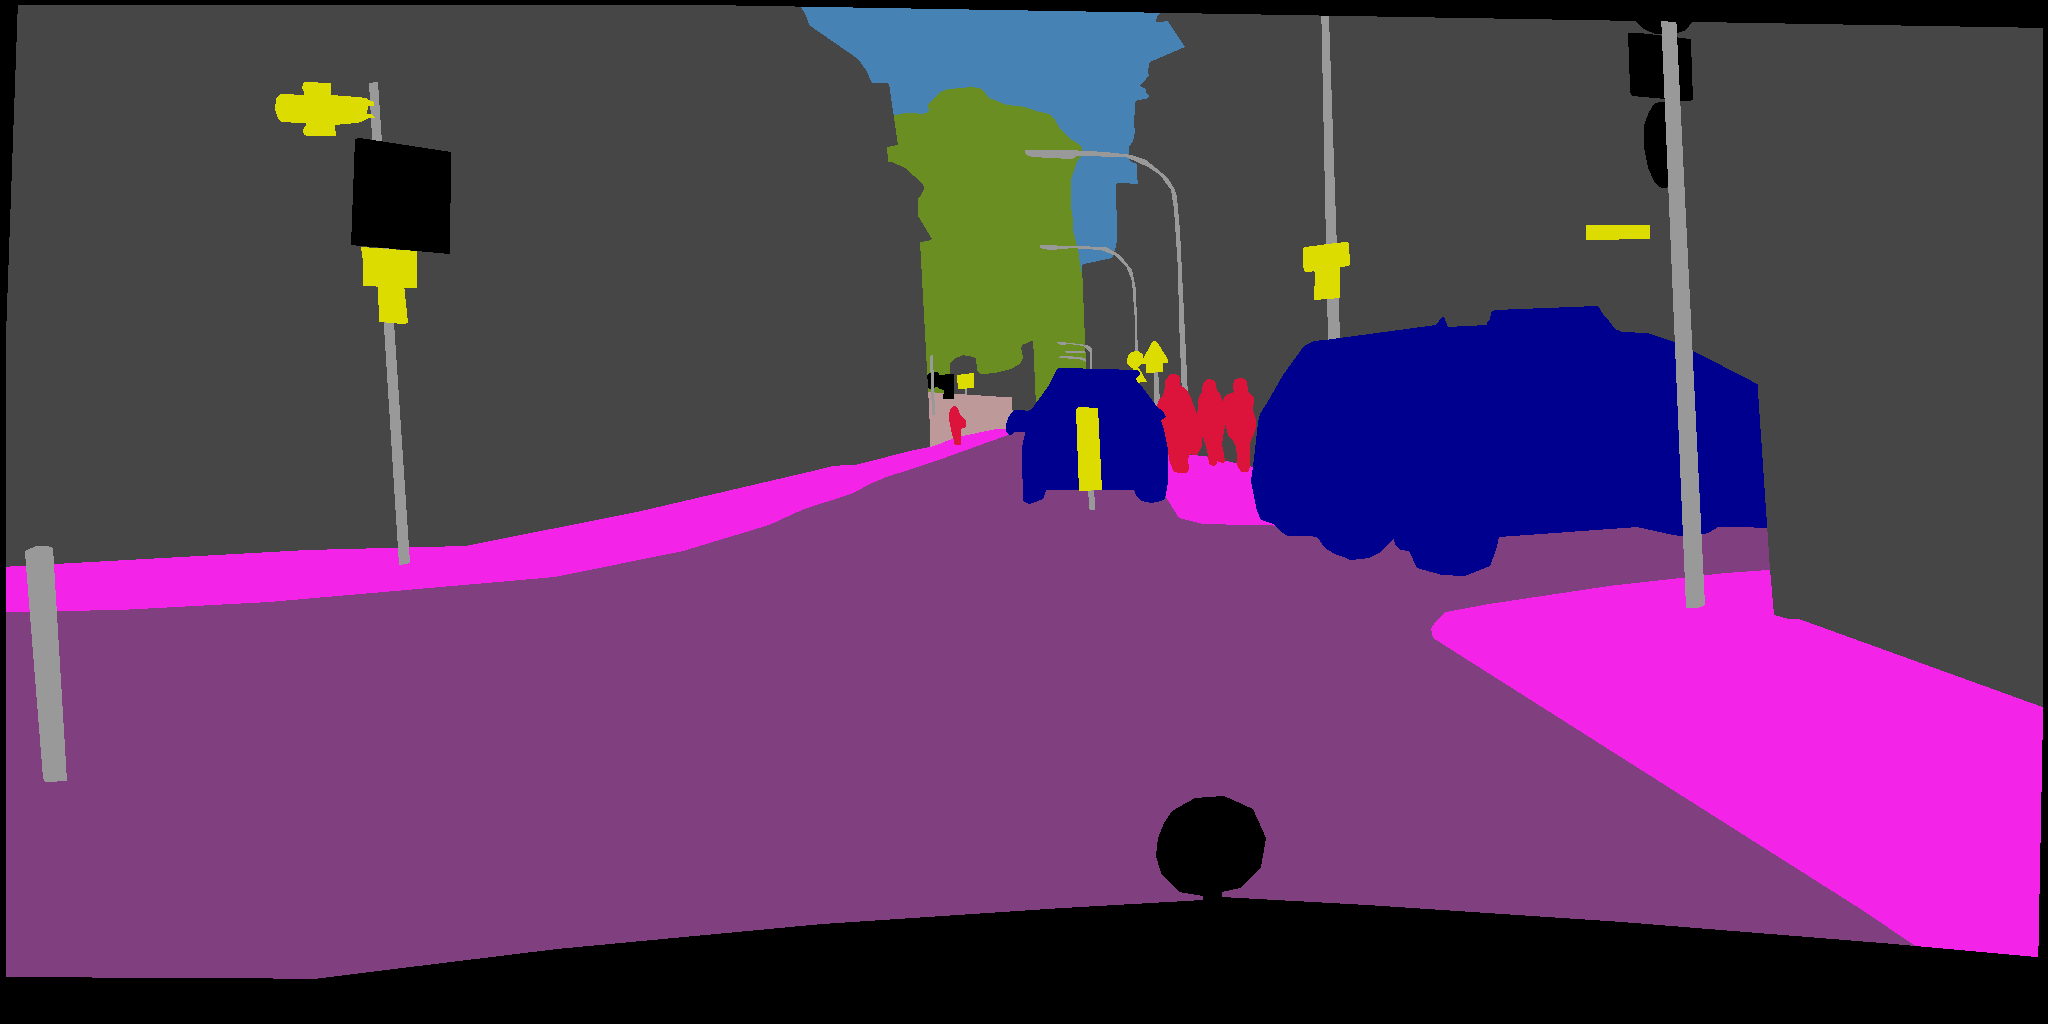

In [15]:
path_col = path.replace('_gtFine_labelTrainIds.png', '_gtFine_color.png')
Image.open(path_col)

In [8]:
gt.unique() , gt.shape

(tensor([  0,   1,   2,   4,   5,   7,   8,  10,  11,  13, 255],
        dtype=torch.uint8),
 torch.Size([1024, 2048]))

In [11]:
idx_bg = torch.where(gt.view(-1) == 255)[0]
idx_bg.shape, idx_bg

(torch.Size([242742]),
 tensor([      0,       1,       2,  ..., 2097149, 2097150, 2097151]))

In [ ]:
## have to replace these idx values with random probability of being either 0, 1 

In [28]:
t = torch.rand((20,19, 19))
t.shape

torch.Size([20, 19, 19])

In [51]:
t[9][-2]

tensor([0.5453, 0.0664, 0.3263, 0.5510, 0.3300, 0.0041, 0.0373, 0.3933, 0.5013,
        0.4777, 0.8399, 0.5230, 0.9674, 0.8247, 0.9597, 0.5932, 0.8471, 0.6615,
        0.1358])

In [39]:
f = torch.zeros((20,20,20)) 
f[:, :19, :19] = t 
# f[0][-2] 

In [40]:
f[:, -1, -1] = 1  ## absorbing state for the background

In [52]:
f[9][-3]

tensor([0.5453, 0.0664, 0.3263, 0.5510, 0.3300, 0.0041, 0.0373, 0.3933, 0.5013,
        0.4777, 0.8399, 0.5230, 0.9674, 0.8247, 0.9597, 0.5932, 0.8471, 0.6615,
        0.1358, 0.0000])

In [53]:
## to load the prediciton of segformerb2 model

### testing for which Transition matrix type to be used 

In [7]:
def calculate_adjacency_matrix(confusion_matrix, k=3):
    ## calculate adjacency_matrix from confusion matrix 
    np.fill_diagonal(confusion_matrix,0) ## removing the dependency of the class with itself  ## its is an inplace argument 
    sorted_indices = np.argsort(confusion_matrix) 
    indices_as_ranks = np.argsort(np.argsort(confusion_matrix)) 
    indices_which_are_topk_as_bool = (indices_as_ranks >= confusion_matrix.shape[1] - k) # shape[1] used as we need to find it along row 
    adjacency_matrix = confusion_matrix * indices_which_are_topk_as_bool
    adjacency_matrix_as_one_hot = adjacency_matrix.copy()
    adjacency_matrix_as_one_hot[adjacency_matrix_as_one_hot>0] = 1 
    
    return adjacency_matrix_as_one_hot

In [8]:
adj =calculate_adjacency_matrix(con, k=5)

In [9]:
adj.shape

(19, 19)

In [10]:
adj[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 1.])

In [14]:
adjacency_matrix_soft = (adj + adj.T) / 10

In [16]:
transition_rate = adjacency_matrix_soft - np.diagflat(np.sum(adjacency_matrix_soft, axis=1))

In [18]:
np.diag(transition_rate)

array([-1.1, -1.3, -2.1, -0.7, -0.9, -1.4, -0.7, -0.7, -2.1, -0.8, -0.9,
       -1.1, -0.8, -1.3, -0.5, -0.6, -0.5, -0.5, -1. ])

In [19]:
transition_rate.sum(0)

array([-8.32667268e-17, -1.94289029e-16, -2.77555756e-17,  2.77555756e-17,
       -1.38777878e-16, -8.32667268e-17, -2.77555756e-17, -5.55111512e-17,
       -2.49800181e-16,  0.00000000e+00,  2.77555756e-17, -2.77555756e-17,
       -2.77555756e-17, -1.38777878e-16,  0.00000000e+00,  2.77555756e-17,
        0.00000000e+00,  2.77555756e-17, -1.11022302e-16])

In [21]:
transition_rate.sum(1)

array([-8.32667268e-17,  0.00000000e+00, -1.38777878e-16,  0.00000000e+00,
        0.00000000e+00,  1.11022302e-16, -5.55111512e-17, -5.55111512e-17,
       -5.55111512e-17, -5.55111512e-17,  8.32667268e-17, -2.77555756e-17,
       -2.77555756e-17,  8.32667268e-17,  5.55111512e-17,  8.32667268e-17,
        0.00000000e+00,  2.77555756e-17,  0.00000000e+00])

In [50]:
betas = 2.5e1

In [51]:
matrix = linalg.expm(
                        np.array(betas * transition_rate, dtype=np.float64))

In [52]:
# matrix.shape

In [53]:
matrix[0]

array([0.05263213, 0.05263174, 0.05263146, 0.05263165, 0.05263137,
       0.05263105, 0.05262969, 0.05263036, 0.05263136, 0.05263199,
       0.05262998, 0.05263259, 0.05263293, 0.05263214, 0.05263243,
       0.05263111, 0.0526297 , 0.05263354, 0.05263276])

In [54]:
## next confusion matrix of results in darkzurich using cityscapes 

In [55]:
matrix[1]

array([0.05263174, 0.05263489, 0.05263162, 0.05263964, 0.05263847,
       0.05263582, 0.05263814, 0.05263793, 0.05263348, 0.05263725,
       0.05263618, 0.0526242 , 0.05262041, 0.05262689, 0.05263254,
       0.05263293, 0.0526318 , 0.05261364, 0.05262243])

### checking betas for similarity matrix derived from protos

In [4]:
model = torch.load('/home/sidd_s/scratch/saved_models/Protoseg/hrnet_w48_proto_lr1x_hrnet_proto_80k_latest.pth')
protos = model['state_dict']['module.prototypes']

In [5]:
def similarity_among_classes(protos):
    cos = torch.nn.CosineSimilarity(dim=0)
    similarity_matrix = []
    for i in range(19):
        per_row_similarity = [] 
        for j in range(19):
            per_row_similarity.append(cos(protos[i][0], protos[j][0]))
        similarity_matrix.append(per_row_similarity)
    similarity_matrix_tensor = torch.FloatTensor(similarity_matrix)     

    # sim_test = similarity_matrix_tensor.clone() 
    # sim_test.fill_diagonal_(-1e17) ## filling extremely low numbers at diagonals for removing them from similarity consideration
    # probas_sim_test = F.softmax(sim_test, dim=1) ## applying softmax to convert into probability distribution 

    # return probas_sim_test, similarity_matrix_tensor
    return similarity_matrix_tensor

similarity_matrix_tensor = similarity_among_classes(protos)

similarity_matrix = np.array(similarity_matrix_tensor)

In [6]:
ind_2_class_dict = {  
    0: "Road",
    1: "Sidewalk", 
    2: "Building",  
    3: "wall",
    4: "fence",  
    5: "Pole", 
    6: "Traffic light",
    7: "Traffic sign",
    8: "Vegetation", 
    9: "Terrain",
    10: "Sky",
    11: "Person",
    12: "Rider",
    13: "Car",
    14: "Truck",
    15: "Bus",
    16: "Train",
    17: "Motorcycle",
    18: "Bicycle"
}

def calculate_adjacency_matrix_knn(similarity_matrix, k): 
    adj = similarity_matrix.copy()
    similar_classes = []
    for row in range(adj.shape[0]):
        row_sim_decrease_inds = np.argsort(adj[row])[::-1]
        knn_indexs = row_sim_decrease_inds[:k] 
        adj[row][knn_indexs] = 1
        adj[row][adj[row]!=1] = 0

        similar_classes.append([ (('Current Class:' + ind_2_class_dict[row]) ,(knn_indexs[i], ind_2_class_dict[knn_indexs[i]])) for i in range(knn_indexs.shape[0])])
    return adj, similar_classes


In [7]:
k = 5

adj, similar_classes = calculate_adjacency_matrix_knn(similarity_matrix, k)

adj_s = (adj + adj.T) / (2 * k) 

tr = adj_s - np.diag(np.sum(adj_s, axis=1))

beta_min = 15

matrix = scipy.linalg.expm(np.array(tr * beta_min, dtype=np.float64))

In [8]:
matrix[10]

array([0.05206792, 0.05375777, 0.05466447, 0.05519611, 0.05630157,
       0.05558731, 0.05821384, 0.0582283 , 0.05597781, 0.053944  ,
       0.06125754, 0.04702434, 0.04555182, 0.04689879, 0.05023954,
       0.05096637, 0.05389285, 0.04442411, 0.04580525])

In [322]:
# tr.sum(1)

In [254]:
# np.diag(tr)

In [9]:
similar_classes[10]

[('Current Class:Sky', (10, 'Sky')),
 ('Current Class:Sky', (8, 'Vegetation')),
 ('Current Class:Sky', (2, 'Building')),
 ('Current Class:Sky', (7, 'Traffic sign')),
 ('Current Class:Sky', (5, 'Pole'))]

In [10]:
tr[10]

array([ 0.        ,  0.        ,  0.1       ,  0.        ,  0.        ,
        0.1       ,  0.        ,  0.1       ,  0.1       ,  0.        ,
       -0.40000004,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ], dtype=float32)

In [11]:
x = 0.05 
y = 0.03
tr[10][8] = 0.1 + 2 * x + y
tr[10][2] = 0.1 + y 
tr[10][7] = 0.1 - y - x 
tr[10][5] = 0.1 - x - y 

In [12]:
tr[10]

array([ 0.        ,  0.        ,  0.13      ,  0.        ,  0.        ,
        0.02      ,  0.        ,  0.02      ,  0.23      ,  0.        ,
       -0.40000004,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ], dtype=float32)

In [13]:
beta_min = 15

In [14]:
matrix = scipy.linalg.expm(np.array(tr * beta_min, dtype=np.float64))

In [15]:
matrix[10]

array([0.05461388, 0.05598873, 0.05515611, 0.05782134, 0.05854284,
       0.05116666, 0.05435454, 0.05010336, 0.06121928, 0.0576171 ,
       0.0588697 , 0.04568873, 0.04441637, 0.04735269, 0.05207343,
       0.05230611, 0.05486069, 0.0435233 , 0.04432487])

In [16]:
similarity_matrix[10]

array([-0.09389959, -0.12291148,  0.00128791, -0.11124361, -0.09902826,
       -0.07015408, -0.07521263, -0.04375174,  0.01210354, -0.12321121,
        1.        , -0.10264361, -0.08833078, -0.08592686, -0.08899493,
       -0.0894008 , -0.09961839, -0.09318795, -0.10486494], dtype=float32)

In [6]:
# model = torch.load('/home/sidd_s/scratch/saved_models/Protoseg/hrnet_w48_proto_lr1x_hrnet_proto_80k_latest.pth')
# protos = model['state_dict']['module.prototypes']

# def similarity_among_classes(protos):
#     cos = torch.nn.CosineSimilarity(dim=0)
#     similarity_matrix = []
#     for i in range(19):
#         per_row_similarity = [] 
#         for j in range(19):
#             per_row_similarity.append(cos(protos[i][0], protos[j][0]))
#         similarity_matrix.append(per_row_similarity)
#     similarity_matrix_tensor = torch.FloatTensor(similarity_matrix)     

#     # sim_test = similarity_matrix_tensor.clone() 
#     # sim_test.fill_diagonal_(-1e17) ## filling extremely low numbers at diagonals for removing them from similarity consideration
#     # probas_sim_test = F.softmax(sim_test, dim=1) ## applying softmax to convert into probability distribution 

#     # return probas_sim_test, similarity_matrix_tensor
#     return similarity_matrix_tensor

# similarity_matrix_tensor = similarity_among_classes(protos)

# similarity_matrix = np.array(similarity_matrix_tensor)

In [7]:
# def calculate_adjacency_matrix_knn(similarity_matrix, k): 
#     adj = similarity_matrix.copy()
#     similar_classes = []
#     for row in range(adj.shape[0]):
#         row_sim_decrease_inds = np.argsort(adj[row])[::-1]
#         knn_indexs = row_sim_decrease_inds[:k] 
#         adj[row][knn_indexs] = 1
#         adj[row][adj[row]!=1] = 0

#         similar_classes.append([ (('Current Class:' + ind_2_class_dict[row]) ,(knn_indexs[i], ind_2_class_dict[knn_indexs[i]])) for i in range(knn_indexs.shape[0])])
#     return adj, similar_classes

# k = 5

# adj, similar_classes = calculate_adjacency_matrix_knn(similarity_matrix, k)

# adj_s = (adj + adj.T) / (2 * k) 


# tr = adj_s - np.diag(np.sum(adj_s, axis=1))

# beta_min = 15 # trial

# matrix = scipy.linalg.expm(np.array(tr * beta_min, dtype=np.float64)) # trial 

### similarity matrix based on miou

In [142]:
# pred image
path = '/home/sidd_s/scratch/results/segformer/cityscapes/frankfurt_000000_000294_leftImg8bit.png'
pred = np.array(Image.open(path))
# pred.shape # (1024, 2048) 
# np.unique(pred) # array([ 0,  1,  2,  5,  6,  7,  8,  9, 10, 11, 13], dtype=uint8) 

In [143]:
gt_path = '/home/sidd_s/scratch/dataset/cityscapes/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_labelTrainIds.png'
gt = np.array(Image.open(gt_path)) 
# gt.shape  # (1024, 2048)
# np.unique(gt) # array([  0,   1,   2,   4,   5,   7,   8,  10,  11,  13, 255], dtype=uint8)

In [168]:
### understanding diff between acc and iou of mmseg 

# label = torch.from_numpy(gt) 
# pred_label = torch.from_numpy(pred)

# # label.unique()

# # pred_label.unique()

# ignore_index = 255 
# mask = (label != ignore_index) 
# pred_label = pred_label[mask]
# label = label[mask]

# # pred_label.shape

# # pred_label.unique()

# # label.shape

# # label.unique()

# num_classes = 19

# intersect = pred_label[pred_label == label]

# # intersect.shape 

# area_intersect = torch.histc(
#         intersect.float(), bins=(num_classes), min=0, max=num_classes - 1)
# area_pred_label = torch.histc(
#         pred_label.float(), bins=(num_classes), min=0, max=num_classes - 1)
# area_label = torch.histc(
#         label.float(), bins=(num_classes), min=0, max=num_classes - 1)
# area_union = area_pred_label + area_label - area_intersect

# area_intersect 

# # area_pred_label

# area_label

# area_union

# area_label.sum()

# area_union.sum()

# all_acc = area_intersect.sum() / area_label.sum() ## very poor meaning, highly biased towards large area classes 
# all_acc

# iou = area_intersect / area_union
# iou 

# acc = area_intersect / area_label
# acc

In [144]:
sim_miou_matrix = np.zeros(shape=[19, 19]) 

In [207]:
gt_segm, res_segm = gt.flatten(), pred.flatten() 

to_ignore = gt_segm == 255
gt_segm, res_segm = gt_segm[~to_ignore], res_segm[~to_ignore] 
n = 19

inds = n * gt_segm + res_segm  ## what the hell? this is doing?

# # inds.shape

mat = np.bincount(inds, minlength=n**2).reshape(n, n) ## area intersect among all classes with each other

In [209]:
# np.unique(gt_segm)

# np.unique(gt_segm)
# np.unique(res_segm*n)

# np.unique(inds) 

# a = np.bincount(np.array([0, 1, 1, 3, 2, 1, 7]), minlength = 9).reshape(3, 3)
# a

# mat

In [174]:
np.fill_diagonal(mat, 0)

In [176]:
mat[0]

array([     0,   4281,     64,      0, 112891,    845,      0,      3,
            0,      0,      0,      0,      0,    399,      0,      0,
            0,      0,      0])

In [177]:
g = mat + mat.T

In [184]:
# g

In [185]:
# g.shape

In [190]:
row_sums = g.sum(axis=1)
row_sums

array([121034,  11189,  18441,      0, 115693,   8011,      0,   2649,
         3310,      7,   2018,   1041,      0,   4131,      0,      0,
            0,      0,      0])

In [198]:
# row_sums[:, np.newaxis].shape

In [201]:
col_sums = g.sum(axis=0)
col_sums ## same as row sums since the matrix is symmetric 

array([121034,  11189,  18441,      0, 115693,   8011,      0,   2649,
         3310,      7,   2018,   1041,      0,   4131,      0,      0,
            0,      0,      0])

In [200]:
g_norm_row = g / row_sums[:, np.newaxis]
g_norm_row[0] 

/tmp/ipykernel_52118/2304567844.py:1: RuntimeWarning: invalid value encountered in divide
  g_norm_row = g / row_sums[:, np.newaxis]


array([0.00000000e+00, 4.66315250e-02, 1.01624337e-03, 0.00000000e+00,
       9.32754433e-01, 7.94817985e-03, 0.00000000e+00, 8.26214122e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.15669977e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [202]:
g_norm_col = g / col_sums[:, np.newaxis]
g_norm_col[0] 

/tmp/ipykernel_52118/4275399626.py:1: RuntimeWarning: invalid value encountered in divide
  g_norm_col = g / col_sums[:, np.newaxis]


array([0.00000000e+00, 4.66315250e-02, 1.01624337e-03, 0.00000000e+00,
       9.32754433e-01, 7.94817985e-03, 0.00000000e+00, 8.26214122e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.15669977e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [233]:
## consideration background classes using the FN values 
gt_segm, res_segm = gt.flatten(), pred.flatten() 

# print(np.unique(gt_segm), np.unique(res_segm))
# print(np.unique(res_segm[gt_segm == 255], return_counts=True))
# print(np.unique(res_segm), res_segm.shape)

cl_b, cl_b_counts = np.unique(res_segm[gt_segm == 255], return_counts=True)

# cl_b_counts.sum()

cl_b_norm = cl_b_counts / cl_b_counts.sum()
cl_b_norm 

## later for all the classes, have to make this array as dim of 20 elements 

array([7.49108107e-01, 3.93215842e-02, 1.75515568e-01, 7.56358603e-03,
       2.11335492e-03, 1.04102298e-02, 1.19468407e-04, 1.57863081e-02,
       6.17940035e-05])

### Mutual information based noise schedule

Have to follow the code from D3PM original codebase: 

There is a requirement of initial distribution: 
we have figured out to be: 

<!-- p(x0) = [ (#road pixels / 1024x2048), (#sidewalk pixels / 1024x2048)  ,...., (#background pixels / 1024x2048)]  
here we can also consider background pixels since, there are also the part of GT... # with background  --> 

p(x0) = [ (#road pixels / norm_value), (#sidewalk pixels / norm_value)  ,...., (#bicycle pixels / norm_value)]  
here we are not considering background since in the validation time, we will need to improve the predicted segmentation mask! 

<!-- One of the question is: in Q_mat transition matrices how to include transition to/from (row/column) background? { init guess is by uniform probability in both row and column) # with background --> 

In [23]:
## init cityscapes gt labels distribution ## train data 
cityscapes_gt_labels_init_distribution = np.load('confusion_similarity_results/cityscapes_gt_labels_init_distribution_without_background.npy',allow_pickle='TRUE').item()

In [24]:
cityscapes_gt_labels_init_distribution

{0: 0.36880975774750857,
 1: 0.06086874054102551,
 2: 0.22819570283385351,
 3: 0.006559296959191458,
 4: 0.008782959202080073,
 5: 0.012275657265534682,
 6: 0.0020849098115345898,
 7: 0.0055286245692937885,
 8: 0.15917384442191498,
 9: 0.011586649487463331,
 10: 0.04011514879508137,
 11: 0.0121730286567891,
 12: 0.0013485701801470244,
 13: 0.07001107820593705,
 14: 0.002676343508357241,
 15: 0.002354059053386268,
 16: 0.0023301726794817553,
 17: 0.0009864704527446806,
 18: 0.004138985628675025}

In [112]:
# sum(cityscapes_gt_labels_init_distribution.values(), 0.0) == 1

In [25]:
class_2_ind = {v: k for k, v in ind_2_class_dict.items()}
# class_2_ind['Background'] = 20  # with background
# class_2_ind

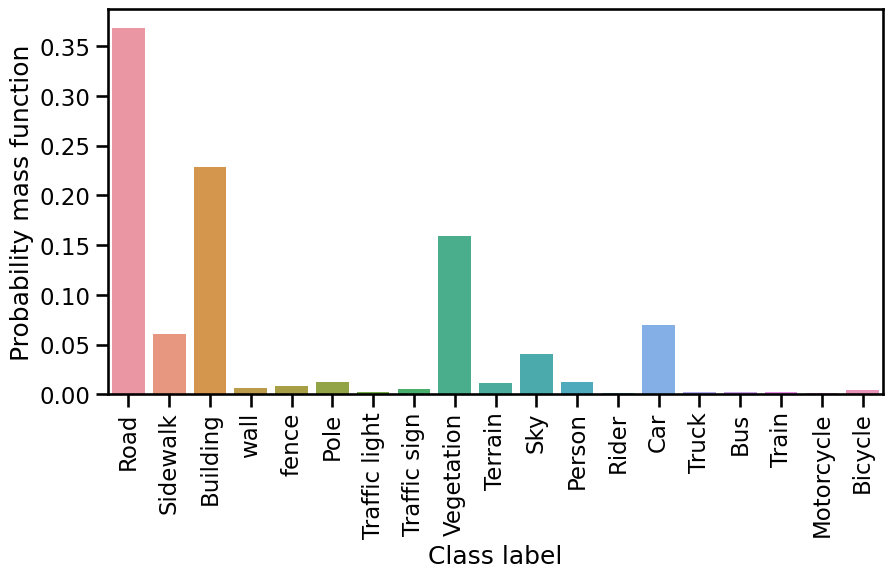

In [26]:
## train data 
sns.set_context('talk')
plt.figure(figsize=(10,5))

keys = list(cityscapes_gt_labels_init_distribution.keys())
keys_for_plot = list(class_2_ind.keys()) 
# get values in the same order as keys, and parse percentage values
vals = [float(cityscapes_gt_labels_init_distribution[k]) for k in keys]
# sns.barplot(x=keys, y=vals)
sns.barplot(x=keys_for_plot, y=vals)

plt.xlabel("Class label")
plt.ylabel("Probability mass function")
plt.xticks(rotation="vertical")

# plt.show() 
plt.savefig('confusion_similarity_results/cityscapes_labels_distribution_without_background.png', bbox_inches = 'tight')

In [30]:
init_distribution = np.array(list(cityscapes_gt_labels_init_distribution.values()))
init_distribution

array([0.36880976, 0.06086874, 0.2281957 , 0.0065593 , 0.00878296,
       0.01227566, 0.00208491, 0.00552862, 0.15917384, 0.01158665,
       0.04011515, 0.01217303, 0.00134857, 0.07001108, 0.00267634,
       0.00235406, 0.00233017, 0.00098647, 0.00413899])

In [12]:
## init cityscapes gt labels distribution ## train data 
seformerb2_city_val_pred_distri = np.load('confusion_similarity_results/segformerb2_cityscapes_pred_val_distribution.npy',allow_pickle='TRUE').item()

In [15]:
seformerb2_city_val_pred_distri

{0: 0.4105492296218872,
 1: 0.05752428150177002,
 2: 0.20906646537780763,
 3: 0.006189051628112793,
 4: 0.006779747009277344,
 5: 0.014103196144104003,
 6: 0.0019112462997436523,
 7: 0.00692063045501709,
 8: 0.15958975315093993,
 9: 0.007254331588745117,
 10: 0.0320015926361084,
 11: 0.012443199157714843,
 12: 0.001925506591796875,
 13: 0.05882715892791748,
 14: 0.002673495292663574,
 15: 0.003502558708190918,
 16: 0.0010153951644897461,
 17: 0.0007603979110717774,
 18: 0.0069627628326416014}

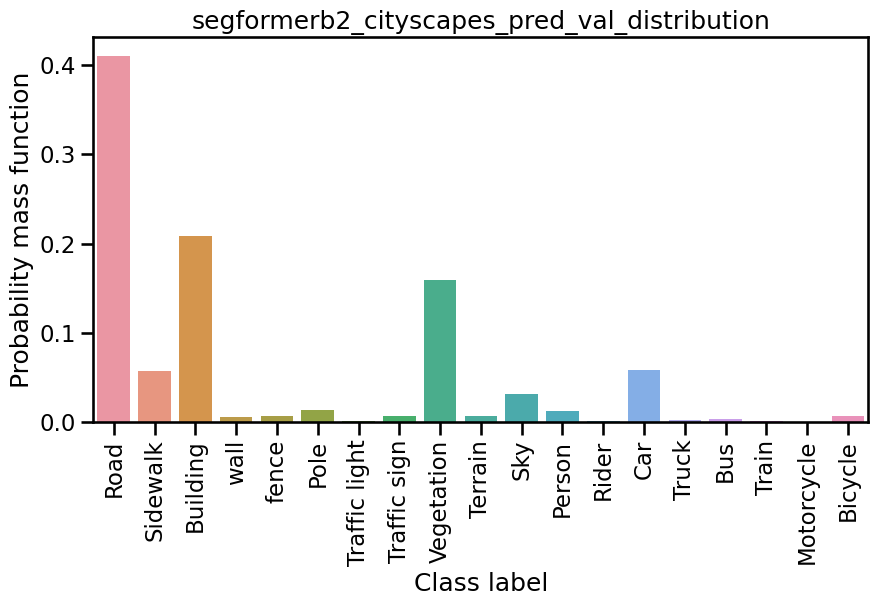

In [19]:
class_2_ind = {v: k for k, v in ind_2_class_dict.items()} 
## val data 
sns.set_context('talk')
plt.figure(figsize=(10,5))

keys = list(seformerb2_city_val_pred_distri.keys())
keys_for_plot = list(class_2_ind.keys()) 
# get values in the same order as keys, and parse percentage values
vals = [float(seformerb2_city_val_pred_distri[k]) for k in keys]
# sns.barplot(x=keys, y=vals)
sns.barplot(x=keys_for_plot, y=vals)

plt.xlabel("Class label")
plt.ylabel("Probability mass function")
plt.xticks(rotation="vertical")
plt.title('segformerb2_cityscapes_pred_val_distribution')

# plt.show() 
plt.savefig('confusion_similarity_results/segformerb2_cityscapes_pred_val_distribution.png', bbox_inches = 'tight')

In [34]:
# transition_rate.sum(1)
# np.diag(transition_rate)

In [66]:
def builder_fn(trans_rate, exponent):
    """
    Function that computes a matrix exponential. 

    Function that, given a float exponent parameter, returns a
    transition matrix T[i, j] = p(x_t = j | x_0 = i) representing a matrix
    exponetial with the given exponent.
    """
    trans_matrix = scipy.linalg.expm(np.array(trans_rate * exponent, dtype=np.float64))
    return trans_matrix

def compute_information_removal_samples_closed_form(trans_rate, init_distribution, min_exponent=1e-4,
                                                    max_exponent=1e5,
                                                    interpolation_steps=256):  
    """Compute mutual information by evaluating a closed form estimate.

  Chooses interpolation steps, then evaluates mutual information for each one.

  Args:
    builder_fn: Function that, given a float exponent parameter, returns a
      transition matrix T[i, j] = p(x_t = j | x_0 = i) representing a matrix
      exponetial with the given exponent.
    init_distribution: Initial distribution of semantic class labels.
    min_exponent: Smallest non-zero exponent to try.
    max_exponent: Largest exponent to try.
    interpolation_steps: How many interpolation steps to try.

  Returns:
    exponents: Array of exponents for which we computed relative mutual
      information removal.
    information_removals: Array of the information removal for each exponent.
  """
    
    query_exponents = np.geomspace(min_exponent, max_exponent,
                                  interpolation_steps)

    information_removals = [] 
    for exponent in query_exponents:  
        trans_matrix = builder_fn(trans_rate, exponent) 
        info_remove = compute_relative_information_removal(trans_matrix, init_distribution) 
        information_removals.append(info_remove) 
    information_removals = np.stack(information_removals)
    
    return query_exponents, information_removals

def compute_relative_information_removal(transition_matrix, init_distribution, use_perplexity=False):

    """Computes removal of (mutual) information after applying a transition matrix.

    I(x_t; x_0) = [ log p(x_0, x_t) - log p(x_0) - log p(x_t)]
                = H(x_0) + H(x_t) - H(x_0, x_t)
         result = 1 - I(x_t; x_0) / H(x_0)
                = 1 - (H(x_0) + H(x_t) - H(x_0, x_t)) / H(x_0)
                = (H(x_0, x_t) - H(x_t)) / H(x_0)

      Args:
        transition_matrix: float32 matrix such that transition_matrix[i, j] = p(x_t
          = j | x_0 = i)
        init_distribution: float32 matrix reprezenting p(x_0)
        use_perplexity: Use conditional perplexity(ish) instead of MI. Assumes
          convergence to uniform. < Uniform thing we don't have :) > 
    
      Returns:
        Normalized information removal, which should be zero for the identity
        matrix,
        and 1 for a transition matrix which does not depend on the initial state.
      """
    # Normalizations for stability ## with logarithms to work with 
    log_transition = np.log(transition_matrix)  ## log 
    log_transition = (log_transition - scipy.special.logsumexp(log_transition, axis=1, keepdims=True)) ## norm axis 1 differnt from the code (differ)
    log_initial = np.log(init_distribution)
    log_initial = (log_initial - scipy.special.logsumexp(log_initial, keepdims=True)) ## check as change  has been done here ## differ
    log_joint = log_initial[:, None] + log_transition ## differ
    log_marginal_after = scipy.special.logsumexp(log_joint, axis=0) ## differ 
    
    joint_entropy = -np.sum(np.where(log_joint == -np.inf, 0.0, np.exp(log_joint) * log_joint))
    initial_entropy = -np.sum(np.where(log_initial == -np.inf, 0.0, np.exp(log_initial) * log_initial)) 
    marginal_after_entropy = -np.sum(np.where(log_marginal_after == -np.inf, 0.0, np.exp(log_marginal_after) * log_marginal_after)) 
    
    if use_perplexity:
        dim = init_distribution.shape[0]
        conditional_perplexity = np.exp(joint_entropy - initial_entropy) 
        return (conditional_perplexity - 1) / (dim - 1) 
    else: 
        information_removal = (joint_entropy - marginal_after_entropy) / initial_entropy
    return information_removal 

def transition_rate_expm(matrix, target_diagonal=1e-3, renormalize_rows=True):  
    """Slightly improved expm for transition rate matrices.

    A transition rate matrix will always have columns that sum to zero, and will
    have nonnegative entries everywhere except the diagonal. We can ensure some
    stability by controlling the magnitude of the diagonal elements and
    renormalizing during each squaring to reduce error.
    
    Args:
    matrix: The matrix to compute a matrix exponential for.
    target_diagonal: Maximum magnitude of the diagonal elements for which it is
      "safe" to approximate e(tA) as I + tA. Will automatically perform more
      iterations until this is small enough to be a good approximation.
    renormalize_cols: Whether to renormalize the columns of the result, with the
      assumption that the rate matrix summed to zero across the columns. This
      property should always hold, so renormalizing can prevent errors from
      exploding.
    
    Returns:
    Approximation of expm(matrix).
    """ 
    max_diag = np.max(-np.diag(matrix)) 
    target_diagonal= ( 1 / 19) ## don't know, cause not going for uniform .. at stationary>>>
    iterations_for_diagonal = np.ceil(np.log2(max_diag) - np.log2(target_diagonal))
    iterations_for_mixing = np.ceil(np.log2(matrix.shape[0]))
    iterations = np.maximum(iterations_for_diagonal, iterations_for_mixing).astype(np.int32)
    tiny_approx = np.eye(matrix.shape[0]) + matrix / (2.0**iterations)    
    mat = tiny_approx.copy()
    for i in range(iterations): 
        mat = np.dot(mat, mat) 
        if renormalize_rows:
          mat = mat / np.sum(mat, axis=1, keepdims=True)
    return mat

def compute_information_removal_samples_by_squaring(rate_matrix,
                                                    init_distribution,
                                                    min_exponent=1e-4,
                                                    max_exponent=1e5,
                                                    interpolation_steps=256,
                                                    use_perplexity=False): 

    """Compute mutual information using repeated squaring.
    
      Reduces a bunch of repeated work by evaluating power-of-two exponents using
      repeated squaring, starting from a few different test offsets to fill the
      gaps between powers of two.
    
      Args:
        rate_matrix: Transition rate matrix of shape [vocab_size, vocab_size]
        init_distribution: Initial distribution of tokens.
        min_exponent: Smallest non-zero exponent to try.
        max_exponent: Largest exponent to try.
        interpolation_steps: Minimum number of interpolation steps to try.
        use_perplexity: Use conditional perplexity(ish) instead of MI
    
      Returns:
        exponents: Array of exponents for which we computed relative mutual
          information removal.
        information_removals: Array of the information removal for each exponent.
    """ 
    # How many powers of two do we need to fill the range?
    powers_of_two = 1 + np.ceil(np.log2(max_exponent) - np.log2(min_exponent)).astype(np.int32)  
    # How many shifts should we evaluate between each power of two? For instance,
    # in addition to evaluating at 1, 2, 4, 8, 16, 32 we might also evaluate at
    # 3/2, 3, 6, 12, 24, 48. Increasing interpolation steps will increase this.
    shifts = np.ceil(interpolation_steps / powers_of_two).astype(np.int32) 
    # Figure out the base exponents (1 and 3/2 in the above example, but there
    # may be more)
    base_exponents = np.exp2(np.log2(min_exponent) + np.linspace(0, 1, shifts, endpoint=False)) 
    
    for base_exponent in base_exponents:  
        base_matrix = transition_rate_expm(base_exponent * rate_matrix)   
        # base_matrix = scipy.linalg.expm(np.array(base_exponent * rate_matrix, dtype=np.float64)) ## using scipy instead of above base matrix calc
        mat = base_matrix
        ys = [] 
        for i in np.arange(powers_of_two): 
            exponent = base_exponent * (2.0**i) 
            info_removal = compute_relative_information_removal(mat, init_distribution, use_perplexity=use_perplexity) 
            mat = np.dot(mat, mat)
            mat = mat / np.sum(mat, axis=1, keepdims=True)
            ys.append((exponent, info_removal)) 
        ys = np.stack(ys)  
        exponents = ys[:,0]
        info_removals = ys[:, 1]
        return exponents.reshape([-1]), info_removals.reshape([-1]) 

def build_mutual_information_schedule(schedule_steps,
                                      exponents,
                                      information_removals,
                                      allow_out_of_bounds=False,
                                      kind="linear"): # "warn" ## logging
    """Compute a mutual-information-based schedule by interpolation.

      Args:
        schedule_steps: Desired number of steps in the schedule.
        exponents: Array of exponents for which we computed relative mutual
          information removal.
        information_removals: Array of the information removal for each exponent.
        allow_out_of_bounds: Whether to allow interpolation for mutual information
          values that are not encountered before `max_exponent`. If True, clips the
          schedule so that it ends at the mutual info for `max_exponent` instead of
          at the desired (near-one) amount of mutual information removal. If False,
          throws an error.
        kind: one of ['linear', 'cosine']. Used to determine the schedule used.
    
      Returns:
        schedule_info_removals: float32[schedule_steps] array giving the amount of
          relative information removal at each point in the schedule. Will linearly
          interpolate between 0 and 1, not including either endpoint, unless this
          goes out of bounds and `allow_out_of_bounds=True`, in which case it may
          linearly interpolate to some value smaller than 1. Note that this may
          not be exactly correct due to the interpolation, but it should be close.
        schedule_exponents: float32[schedule_steps] array with the exponents
          needed to obtain each level of information removal. Note that this array
          does NOT include zero or infinity at the beginning/end, which are needed
          to obtain zero or one information removal. The caller should take care of
          padding so that the schedule takes the appropriate number of steps, for
          instance by adding zero to the front and ensuring that the sequence is
          replaced by a mask at the last step.
    """
    exponents = np.array(exponents)
    information_removals = np.array(information_removals)
    # Sort by exponent.
    permutation = np.argsort(exponents) 
    exponents = exponents[permutation]
    information_removals = information_removals[permutation] 
    # Fix out-of-order information removals due to numerical error.
    cmax_info_removal = np.maximum.accumulate(information_removals)
    bad = information_removals <= np.concatenate([[0], cmax_info_removal[:-1]])
    exponents = exponents[~bad]
    information_removals = information_removals[~bad]  
    # Add zero at the start.
    exponents = np.concatenate([[0], exponents])
    information_removals = np.concatenate([[0], information_removals])    

    # Interpolate monotonically so that our exponents are non-decreasing
    interpolator = scipy.interpolate.PchipInterpolator(information_removals, exponents, extrapolate=False)  # monotonic cubic interpolation 

    if kind == "linear":
        schedule_info_removals = np.linspace(0, 1, schedule_steps + 2)[1:-1]   # skipping the first and the last step 
    
    elif kind == "cosine": 
        s = 0.008 
        def cosine_fn(step):
          return np.cos((step / schedule_steps + s) / (1 + s) * np.pi / 2) 
        
        schedule_info_removals = 1 - cosine_fn(np.arange(schedule_steps)) 
    else:
        raise ValueError(f"kind {kind} is not supported.") 

    if schedule_info_removals[-1] > information_removals[-1]: 
        if allow_out_of_bounds: 
            if allow_out_of_bounds == "warn": 
                ## logging 
                # "build_mutual_information_schedule: Requested mutual "
                # "information removal value schedule_info_removals[-1] for "
                # "schedule was larger than largest observed value "
                # information_removals[-1]. Clipping schedule to this largest "
                # "observed value; consider increasing extrapolation range.",
                pass 
            schedule_info_removals = (np.linspace(0, information_removals[-1], schedule_steps + 1)[1:]) 
        else:
            raise ValueError(
            "Requested mutual information removal value "
            f"{schedule_info_removals[-1]} for schedule was larger than largest "
            f"observed value {information_removals[-1]}") 
            
    schedule_exponents = interpolator(schedule_info_removals) 
    return schedule_info_removals, schedule_exponents 

In [89]:
schedule_steps = 3 # changed from 20 steps to 3 steps for testing 
# below hyperparams are same as the D3PMs
mutual_info_min_exponent = 1e-4
mutual_info_max_exponent = 1e+5
mutual_info_interpolation_steps = 256

# ## using this way
query_exponents, query_info_removals = compute_information_removal_samples_closed_form(
                                                    transition_rate, 
                                                    init_distribution,
                                                    min_exponent=mutual_info_min_exponent,
                                                    max_exponent=mutual_info_max_exponent,
                                                    interpolation_steps=mutual_info_interpolation_steps) 

# query_exponents, query_info_removals = compute_information_removal_samples_by_squaring(
#                                                     transition_rate, 
#                                                     init_distribution,
#                                                     min_exponent=mutual_info_min_exponent,
#                                                     max_exponent=mutual_info_max_exponent,
#                                                     interpolation_steps=mutual_info_interpolation_steps) 

## above both query exponents and query info removals are giving nearly the approximate results!!

# linear noise schedule
_, middle_exponents = build_mutual_information_schedule(
        schedule_steps, 
        query_exponents, 
        query_info_removals, kind='linear') 

# cosine noise schedule
# _, middle_exponents = build_mutual_information_schedule(
#         schedule_steps, 
#         query_exponents, 
#         query_info_removals, kind='cosine') 

exponents = np.concatenate([np.zeros([1]), middle_exponents])
## rounding it off 
min_exponent = middle_exponents[0] 
powers = np.round(exponents / min_exponent).astype(np.int32) 

In [90]:
exponents # with linear scheduling 

array([ 0.        ,  3.34867965, 11.74859687, 37.45633462])

In [37]:
# exponents # with cosine scheduling 

In [91]:
# with linear time scheduling
t = 2
# beta = powers[t + 1] - powers[t]  ## beta value at timestep t 
beta = powers[t + 1]  ## cummulative value at timestep t for beta 
transition_matrix = builder_fn(transition_rate, beta) 
transition_matrix[1]

array([2.90325357e-01, 4.97154970e-01, 6.50481983e-02, 3.67233075e-03,
       4.50251610e-03, 1.26351150e-02, 5.84199212e-04, 1.61729694e-03,
       5.23704721e-02, 1.00848721e-02, 1.92472631e-03, 1.58677523e-02,
       2.11570759e-03, 2.69208067e-02, 5.28480435e-04, 9.76035466e-04,
       3.25889647e-04, 8.11882548e-04, 1.25333911e-02])

In [92]:
transition_matrix.shape

(19, 19)

In [93]:
transition_matrix.sum(1) ## necessary to be one

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.])

In [94]:
transition_matrix.sum(0)

array([1.83013291, 1.20357275, 4.58241445, 0.11695596, 0.15016075,
       0.42842402, 0.25837506, 0.40829225, 3.2867542 , 0.12145893,
       1.06589138, 1.09852727, 0.28451274, 1.78514282, 0.32867439,
       0.74692369, 0.234328  , 0.19078446, 0.87867397])

In [97]:
num_classes = 19

q_mats = torch.tensor(transition_matrix)  ## last step cumulative transition probability matrix
extended_q_mats = torch.zeros(num_classes + 1 ,num_classes +1 ) 
extended_q_mats[:q_mats.shape[0],:q_mats.shape[1]] = q_mats
extended_q_mats = extended_q_mats[None, :, :]

def logits_to_categorical(logits):
    uniform_noise = torch.rand_like(logits)
    ## # To avoid numerical issues clip the uniform noise to a minimum value
    uniform_noise = torch.clamp(uniform_noise, min=torch.finfo(uniform_noise.dtype).tiny, max=1.)
    gumbel_noise = - torch.log(-torch.log(uniform_noise))
    sample = (gumbel_noise + logits).argmax(dim=1)
    return sample

## prediction at last time step of diffusion forward process 

def q_stationary_sample(path):
    x0 = torch.tensor(np.array(Image.open(path))) # a cityscapes validation gt
    x0[x0 == 255] = 19
    x0 = x0.unsqueeze(dim=0)
    # print(x0.shape) # torch.Size([1, 1024, 2048])
    B,H,W = x0.shape
    x0_onehot = F.one_hot(x0.view(B, -1).to(torch.int64), num_classes+1).to(torch.float32) 
    out = torch.matmul(x0_onehot, extended_q_mats) 
    out = out.view(B, num_classes+1, H, W)
    logits = torch.log(out + torch.finfo(torch.float32).eps)  # eps approx 1e-7
    out_sample = logits_to_categorical(logits) 
    return out_sample
    
## getting distribution 
folder = "/home/sidd_s/scratch/dataset/cityscapes/gtFine/val"  
gt_dataset_num_of_labels = dict.fromkeys(range(20),0) 
num_gts = 0 
for root, dirs, files in os.walk(folder, topdown=False):
    for name in tqdm(files): 
        path = os.path.join(root, name) 
        if path.find('_gtFine_labelTrainIds.png')!=-1:
            num_gts += 1
            gt = np.array(q_stationary_sample(path)) # stationary sample
            unique_labels, unique_labels_counts = np.unique(gt, return_counts = True)
            assert unique_labels_counts.sum() == 1024*2048
            for ind in range(unique_labels.shape[0]):
                gt_dataset_num_of_labels[unique_labels[ind]] += unique_labels_counts[ind]

assert num_gts == 500 ## number of cityscapes validation images

total_num_pixels = gt.reshape(1, -1).shape[1] * num_gts 
gt_dataset_labels_init_distribution = {k: v / total_num_pixels for k, v in gt_dataset_num_of_labels.items()}
# save in numpy format
np.save('confusion_similarity_results/q_stationary_sample_'+ str(schedule_steps) +'_steps_cityscapes_val_distribution.npy', gt_dataset_labels_init_distribution)
# loading dictionary 
# cityscapes_gt_labels_init_distribution = np.load('cityscapes_gt_labels_init_distribution.npy',allow_pickle='TRUE').item()
print(gt_dataset_labels_init_distribution) 
print('Finished it')    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1335/1335 [03:14<00:00,  6.85it/s]
0it [00:00, ?it/s]

{0: 0.04384692192077637, 1: 0.05534249210357666, 2: 0.0594293794631958, 3: 0.0656245813369751, 4: 0.07071306610107422, 5: 0.06312588596343995, 6: 0.06118376064300537, 7: 0.0657660665512085, 8: 0.06975719547271729, 9: 0.06725554180145264, 10: 0.0569489688873291, 11: 0.04859399604797363, 12: 0.043131808280944824, 13: 0.044072882652282715, 14: 0.046208212852478024, 15: 0.04340731906890869, 16: 0.03694346618652344, 17: 0.03256345272064209, 18: 0.02051145839691162, 19: 0.005573543548583984}
Finished it


In [96]:
# np.save('confusion_similarity_results/q_stationary_sample_'+ str(schedule_steps) +'_steps_cityscapes_val_distribution.npy', gt_dataset_labels_init_distribution)

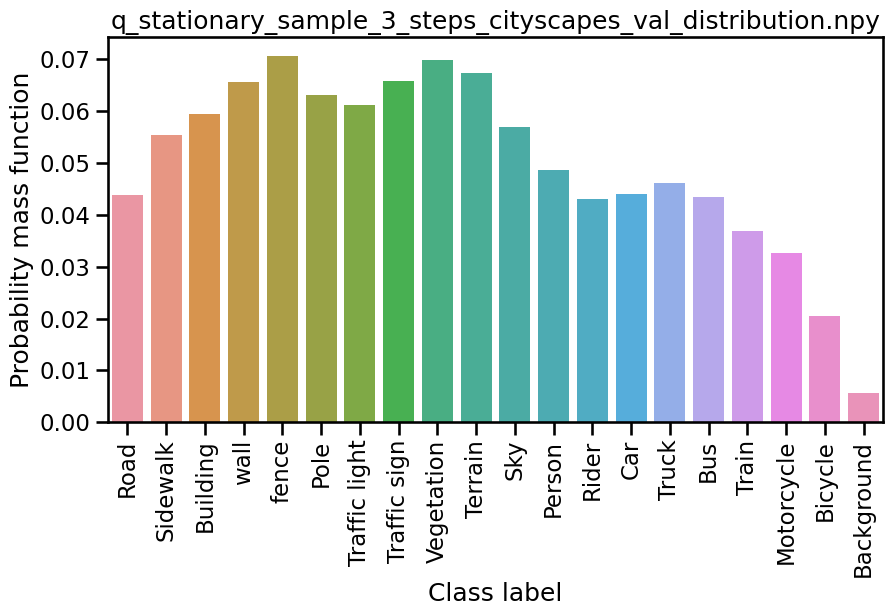

In [98]:
q_stationary_sample_cityscapes_val_distribution = np.load('confusion_similarity_results/q_stationary_sample_'+ str(schedule_steps) +'_steps_cityscapes_val_distribution.npy',allow_pickle='TRUE').item()   
class_2_ind = {v: k for k, v in ind_2_class_dict.items()}  
class_2_ind['Background'] = 19  
## val data 
sns.set_context('talk')
plt.figure(figsize=(10,5))

keys = list(q_stationary_sample_cityscapes_val_distribution.keys())
keys_for_plot = list(class_2_ind.keys()) 
# get values in the same order as keys, and parse percentage values
vals = [float(q_stationary_sample_cityscapes_val_distribution[k]) for k in keys]
# sns.barplot(x=keys, y=vals)
sns.barplot(x=keys_for_plot, y=vals)

plt.xlabel("Class label")
plt.ylabel("Probability mass function")
plt.xticks(rotation="vertical")
plt.title('q_stationary_sample_'+ str(schedule_steps) +'_steps_cityscapes_val_distribution.npy')

# plt.show() 
plt.savefig('confusion_similarity_results/q_stationary_sample_'+ str(schedule_steps) +'_steps_cityscapes_val_distribution.png', bbox_inches = 'tight')

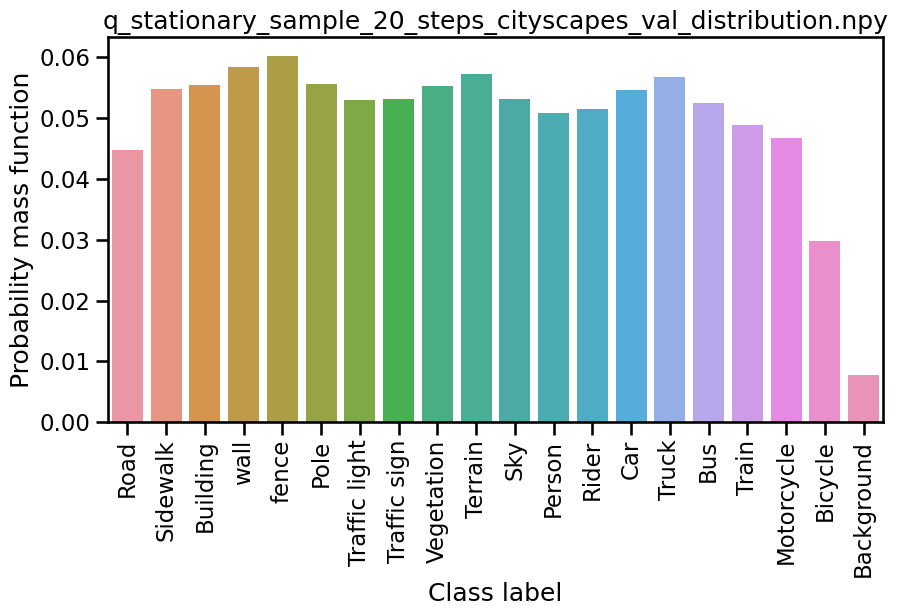

In [99]:
schedule_steps = 20

q_stationary_sample_cityscapes_val_distribution = np.load('confusion_similarity_results/q_stationary_sample_'+ str(schedule_steps) +'_steps_cityscapes_val_distribution.npy',allow_pickle='TRUE').item()   
class_2_ind = {v: k for k, v in ind_2_class_dict.items()}  
class_2_ind['Background'] = 19  
## val data 
sns.set_context('talk')
plt.figure(figsize=(10,5))

keys = list(q_stationary_sample_cityscapes_val_distribution.keys())
keys_for_plot = list(class_2_ind.keys()) 
# get values in the same order as keys, and parse percentage values
vals = [float(q_stationary_sample_cityscapes_val_distribution[k]) for k in keys]
# sns.barplot(x=keys, y=vals)
sns.barplot(x=keys_for_plot, y=vals)

plt.xlabel("Class label")
plt.ylabel("Probability mass function")
plt.xticks(rotation="vertical")
plt.title('q_stationary_sample_'+ str(schedule_steps) +'_steps_cityscapes_val_distribution.npy')

# plt.show() 
plt.savefig('confusion_similarity_results/q_stationary_sample_'+ str(schedule_steps) +'_steps_cityscapes_val_distribution.png', bbox_inches = 'tight')

In [35]:
# # with cosine time scheduling 
# t = 1
# # beta = powers[t + 1] - powers[t]  ## beta value at timestep t 
# beta = powers[t + 1]  ## cummulative value at timestep t for beta 
# transition_matrix = builder_fn(transition_rate, beta) 
# transition_matrix[-1]

In [79]:
transition_matrix.sum(1) ## necessary to be one

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.])

In [78]:
transition_matrix.sum(0)

array([5.09438708, 0.86727819, 4.6397479 , 0.03536898, 0.05305737,
       0.21771907, 0.04260175, 0.10292113, 4.58621797, 0.08198936,
       1.35042924, 0.30495182, 0.04470476, 1.29569976, 0.01982885,
       0.06538527, 0.00659646, 0.01297863, 0.17813639])